# Stage 2:  Initial Exploratory Data Analysis

In [1]:
import praw
import pymongo
from pymongo import MongoClient
import json
import pandas as pd
pd.set_option('display.max_colwidth', None)
import datetime
import pprint
from bson import ObjectId


import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read the raw data file
df = pd.read_csv('https://raw.githubusercontent.com/jonpresto/Opinion-Mining-Reddit/main/Stage-02-Cleaning-Exporing/dataset/2019_may2021_historical_detailed.csv')

In [3]:
# check and remove missing data and duplicate rows
df.shape

(6618, 8)

In [4]:
# check datatype of each column
df.dtypes

submission_id                 object
submission_score               int64
submission_title              object
submission_link_flair_text    object
submission_selftext           object
reply_author                  object
reply_body                    object
reply_created_utc              int64
dtype: object

In [5]:
# check for nulls
df.isnull().sum()

submission_id                    0
submission_score                 0
submission_title                 0
submission_link_flair_text    4298
submission_selftext           2334
reply_author                     0
reply_body                       0
reply_created_utc                0
dtype: int64

In [6]:
# drop null values if all columns are nulls
df.dropna(inplace=True,how='all')
df.shape

(6618, 8)

In [7]:
# check for unique values
df.nunique()

submission_id                  639
submission_score                28
submission_title               622
submission_link_flair_text       7
submission_selftext            416
reply_author                  4107
reply_body                    6010
reply_created_utc             3390
dtype: int64

In [8]:
# what are the duplicates?
replies_counts = df.reply_body.value_counts()
replies_counts[replies_counts>=2][:10]


[removed]                                                                164
[deleted]                                                                131
Thank you!                                                                26
Done, please upvote my Pinned Post! Oh please! join r/banglaAudiobook     12
Thanks                                                                    10
yes                                                                        8
Thanks!                                                                    8
Nice                                                                       8
Yeah, I’m bored every time they are on screen now.                         6
Mommy!!! 🤤                                                                 6
Name: reply_body, dtype: int64

In [9]:
# we do not want deleted or removed posts
status_deleted = "[deleted]"
status_removed = "[removed]"

# we don't want deleted post anyway - delete all of them with the [deleted] or [removed]
df.drop(index = df[df['reply_body']==status_deleted].index, inplace=True)
df.drop(index = df[df['reply_body']==status_removed].index, inplace=True)

In [10]:
df.shape

(6323, 8)

In [11]:
#df_backup = df.copy()
# df = df_backup.copy()

In [12]:
# drop duplicates of the same author, same reply text within the same submission
# but keep first and only for reply
df.drop_duplicates(subset=['submission_id','reply_author','reply_created_utc','reply_body'],
                   keep='first', inplace=True)


In [13]:
# check count of unique values again
df.nunique()

submission_id                  639
submission_score                28
submission_title               622
submission_link_flair_text       7
submission_selftext            416
reply_author                  4107
reply_body                    6008
reply_created_utc             3351
dtype: int64

Now that we've cleaned the data by removing null values and duplicates, we can start looking at some simple statistics.  Specifically, we can understand what are the most popular threads based on number of replies, or number of word counts in replies, number of upvotes.  

We can also start getting some basic context about what people are discussing in these threads.

In [14]:
# let's strip extra white space first and save to new column
df['reply'] = df['reply_body'].str.strip()

In [15]:
# Introduce new column to estimate count of words to support answering questions above
df['reply_char_counts'] = df['reply'].str.len()

In [16]:
df.head(3)

,submission_id,submission_score,submission_title,submission_link_flair_text,submission_selftext,reply_author,reply_body,reply_created_utc,reply,reply_char_counts
0,aglcrj,1,Goodnotes 4 vs. Goodnotes 5 right now,NaN,"I have used Goodnotes 4 for work a ton. And I do mean a ton. I bought and downloaded 5 yesterday, transfer was easy. I realized I can't use the Mac App with 5. Right? Changes I made in 5 aren't synced to the desktop app. Also I kept getting a syncing error in 5. What was it syncing with? I am going to continue to play with it but I am not sure I feel comfortable diving in yet.",Mauri97,"I'm getting a ton of bugs with 5 as well (snappy lines, no response at times) and for some reason the ability to sync to google drive and to download multiple files at once from google drive is gone.\n\n I think they need some time to cope with the new launch.",1547656134,"I'm getting a ton of bugs with 5 as well (snappy lines, no response at times) and for some reason the ability to sync to google drive and to download multiple files at once from google drive is gone.\n\n I think they need some time to cope with the new launch.",258
1,aglcrj,1,Goodnotes 4 vs. Goodnotes 5 right now,NaN,"I have used Goodnotes 4 for work a ton. And I do mean a ton. I bought and downloaded 5 yesterday, transfer was easy. I realized I can't use the Mac App with 5. Right? Changes I made in 5 aren't synced to the desktop app. Also I kept getting a syncing error in 5. What was it syncing with? I am going to continue to play with it but I am not sure I feel comfortable diving in yet.",nathanwj,Goodnotes 5 is not yet compatible with the desktop app as it says in the release notes. There will be more features added in the near future.,1547658625,Goodnotes 5 is not yet compatible with the desktop app as it says in the release notes. There will be more features added in the near future.,141
2,aglcrj,1,Goodnotes 4 vs. Goodnotes 5 right now,NaN,"I have used Goodnotes 4 for work a ton. And I do mean a ton. I bought and downloaded 5 yesterday, transfer was easy. I realized I can't use the Mac App with 5. Right? Changes I made in 5 aren't synced to the desktop app. Also I kept getting a syncing error in 5. What was it syncing with? I am going to continue to play with it but I am not sure I feel comfortable diving in yet.",Rowyfo,"I haven't downloaded GN5 yet but watched a walkthrough and I did see that there's a snap option to check and uncheck, I think somewhere in pen options. Hope that helps!",1547662874,"I haven't downloaded GN5 yet but watched a walkthrough and I did see that there's a snap option to check and uncheck, I think somewhere in pen options. Hope that helps!",168


In [17]:
# check some results
df[df['reply_char_counts'] < 10].head()

,submission_id,submission_score,submission_title,submission_link_flair_text,submission_selftext,reply_author,reply_body,reply_created_utc,reply,reply_char_counts
131,alkvoc,1,I've been thinking to stick with GN 4 until GN 5 is ready to go.,NaN,"I have literally hundred of thousands of pages written using GN 4. I downloaded GN 5 thinking that it'll be a upgrade, but it isn't.\n\nThey didn't even put the same colors that existed in GN4 to write... they messed around with my kind of summary with that ""favorites""...\n\nI'm using an Ipad Air 2 and with GN 5 it overheats very quick...\n\nIt's good that I can import my things to GN 5... so I've been thinking to stick with GN 4 until GN 5 is ready to go.",Quirky_Coffee,Yeah I do,1548922718,Yeah I do,9
132,alkvoc,1,I've been thinking to stick with GN 4 until GN 5 is ready to go.,NaN,"I have literally hundred of thousands of pages written using GN 4. I downloaded GN 5 thinking that it'll be a upgrade, but it isn't.\n\nThey didn't even put the same colors that existed in GN4 to write... they messed around with my kind of summary with that ""favorites""...\n\nI'm using an Ipad Air 2 and with GN 5 it overheats very quick...\n\nIt's good that I can import my things to GN 5... so I've been thinking to stick with GN 4 until GN 5 is ready to go.",Cucobr,for sure.,1548931219,for sure.,9
150,aqzvf0,1,Cloud notes,NaN,"Hi! If I sinc my notes in Goodnotes (apple ipad) with google drive, it means that I can read my notes as pdf on my phone and pc? Or is it just a backup of my notes that I can’t use?",pittu2752,Okok,1550317018,Okok,4
151,aqzvf0,1,Cloud notes,NaN,"Hi! If I sinc my notes in Goodnotes (apple ipad) with google drive, it means that I can read my notes as pdf on my phone and pc? Or is it just a backup of my notes that I can’t use?",pittu2752,Thanks,1550317067,Thanks,6
155,asuisg,3,Support requests do not work on safari,NaN,"Thought I would call out again for support for naming bookmarks on version 5 given that we have had 28 days and 8 released since we were told that the team are working on it - they have done an excellent job adding search across notebooks, so not complaining. However, cannot submit to support page because the ‘bot filter’ is not displayed on safari on iPad....",universal_hype80085,nice list,1622867861,nice list,9


In [18]:
df['reply_word_counts_by_space'] = df['reply'].str.split().str.len()

In [19]:
# check results
#df[df['reply_char_counts'] < 30].head(2)
df[df['reply_char_counts'] < 30].tail(2)

,submission_id,submission_score,submission_title,submission_link_flair_text,submission_selftext,reply_author,reply_body,reply_created_utc,reply,reply_char_counts,reply_word_counts_by_space
6613,nob4jo,1,Pasting text from outside Goodnotes,NaN,I’m curious to know would it be possible to select text from outside Goodnotes to then paste into a Goodnotes document directly? For example copying and pasting long alphanumeric passcodes from Lastpass into Goodnotes directly?,reddit_lss_43,Testing-MessageTwo-30987,1622871499,Testing-MessageTwo-30987,24,1
6616,nob4jo,1,Pasting text from outside Goodnotes,NaN,I’m curious to know would it be possible to select text from outside Goodnotes to then paste into a Goodnotes document directly? For example copying and pasting long alphanumeric passcodes from Lastpass into Goodnotes directly?,bluevinylmoon7,thanks!,1622871499,thanks!,7,1


In [20]:
# summary stats by those new numerical values we made
df.describe()

,submission_score,reply_created_utc,reply_char_counts,reply_word_counts_by_space
count,6323.000000,6.323000e+03,6323.000000,6323.000000
mean,2.580263,1.610551e+09,163.619801,28.925826
std,8.121507,1.792379e+07,284.995360,49.515237
min,0.000000,1.547656e+09,1.000000,1.000000
25%,1.000000,1.603390e+09,34.000000,6.000000
50%,1.000000,1.622222e+09,81.000000,15.000000
75%,1.000000,1.622870e+09,185.000000,34.000000
max,132.000000,1.622871e+09,8928.000000,1525.000000


In [21]:
df.dtypes

submission_id                 object
submission_score               int64
submission_title              object
submission_link_flair_text    object
submission_selftext           object
reply_author                  object
reply_body                    object
reply_created_utc              int64
reply                         object
reply_char_counts              int64
reply_word_counts_by_space     int64
dtype: object

In [22]:
# insight 1. calculate summary stats for reply word counts by space
df[['reply_word_counts_by_space']].describe()

,reply_word_counts_by_space
count,6323.000000
mean,28.925826
std,49.515237
min,1.000000
25%,6.000000
50%,15.000000
75%,34.000000
max,1525.000000


<AxesSubplot:ylabel='Frequency'>

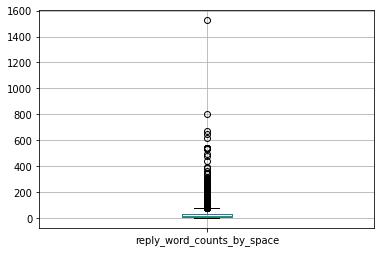

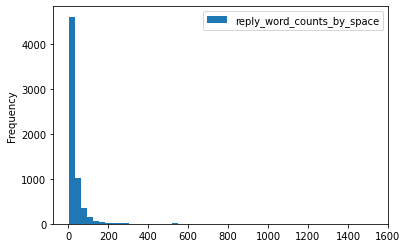

In [23]:
# here's a boxplot and histogram visual of the distribution of word counts by space
df[['reply_word_counts_by_space']].boxplot(column=['reply_word_counts_by_space']) 
df[['reply_word_counts_by_space']].plot.hist(bins=50)

Average number of word counts per reply is about 29 words

In [24]:
# insight 2. calculate summary stats for character counts per reply
df[['reply_char_counts']].describe()

,reply_char_counts
count,6323.000000
mean,163.619801
std,284.995360
min,1.000000
25%,34.000000
50%,81.000000
75%,185.000000
max,8928.000000


<AxesSubplot:ylabel='Frequency'>

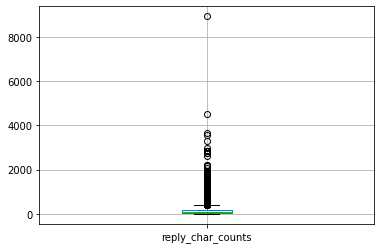

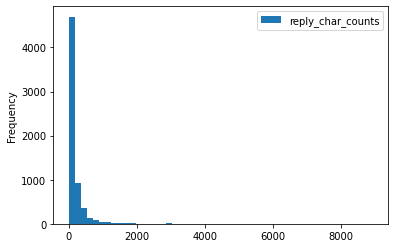

In [25]:
# here's a boxplot and histogram visual of the distribution of char counts per reply
df[['reply_char_counts']].boxplot(column=['reply_char_counts']) 
df[['reply_char_counts']].plot.hist(bins=50)

Average character count per reply is 163.6

In [26]:
# insight 3. calculate summary stats for count of replies
df[['submission_id', 'reply']].groupby(['submission_id']).agg(
    {'reply': 'count'}).reset_index().describe()

,reply
count,639.000000
mean,9.895149
std,9.081655
min,1.000000
25%,3.000000
50%,6.000000
75%,20.000000
max,42.000000


The average number of replies per thread is about 10.

<AxesSubplot:ylabel='Frequency'>

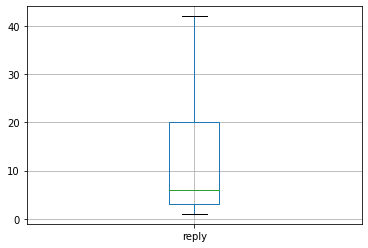

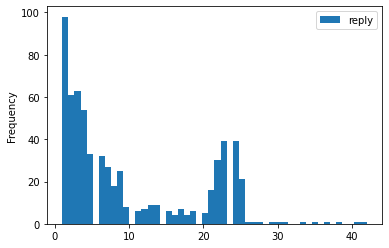

In [27]:
# here's a boxplot and histogram visual of the distribution of reply count
%matplotlib inline
df[['submission_id', 'reply']].groupby(['submission_id']).agg(
    {'reply': 'count'}).reset_index().boxplot(column=['reply']) 

df[['submission_id', 'reply']].groupby(['submission_id']).agg(
    {'reply': 'count'}).reset_index().plot.hist(bins=50)

In [28]:
# insight 4. calculate average number of upvotes for each thread

submission_cols = [col for col in df.columns if 'submission' in col]
submission_df = df[submission_cols].copy()
submission_df.drop_duplicates(inplace=True)
submission_df.shape

submission_df[['submission_id', 'submission_score']].groupby(['submission_id']).agg(
    {'submission_score': 'sum'}).reset_index().describe()


,submission_score
count,639.000000
mean,2.395931
std,8.022581
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,132.000000


<AxesSubplot:ylabel='Frequency'>

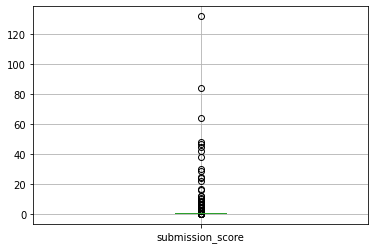

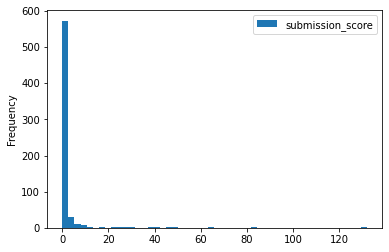

In [29]:
# here's a boxplot visual and histogram of upvotes
%matplotlib inline
submission_df[['submission_id', 'submission_score']].groupby(['submission_id']).agg(
    {'submission_score': 'sum'}).reset_index().boxplot(column=['submission_score']) 

submission_df[['submission_id', 'submission_score']].groupby(['submission_id']).agg(
    {'submission_score': 'sum'}).reset_index().plot.hist(bins=50)

The average number of upvotes per thread is about 2.39, but looking at the visuals, this measure is highly skewed.

In [30]:
# insight 5. Authors with the highest number of replies
df.groupby(['reply_author']).reply.count().sort_values(ascending=False).head()

reply_author
AutoModerator    124
XF939495xj6       29
davemacdo         24
moegnus           24
Topherho          23
Name: reply, dtype: int64

In [31]:
df[df.reply_author=='AutoModerator'].head()

,submission_id,submission_score,submission_title,submission_link_flair_text,submission_selftext,reply_author,reply_body,reply_created_utc,reply,reply_char_counts,reply_word_counts_by_space
164,asuisg,3,Support requests do not work on safari,NaN,"Thought I would call out again for support for naming bookmarks on version 5 given that we have had 28 days and 8 released since we were told that the team are working on it - they have done an excellent job adding search across notebooks, so not complaining. However, cannot submit to support page because the ‘bot filter’ is not displayed on safari on iPad....",AutoModerator,"I did not read your argument. Due to me not reading your argument, it is now invalid. Due to your argument being invalid, I am therefore declared the winner of this debate.\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/BanVideoGames) if you have any questions or concerns.*",1622867861,"I did not read your argument. Due to me not reading your argument, it is now invalid. Due to your argument being invalid, I am therefore declared the winner of this debate.\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/BanVideoGames) if you have any questions or concerns.*",360,56
256,ba2bcy,1,GoodNotes diary [ENG sub],NaN,NaN,AutoModerator,"\n\nPlease remember we are here as a representation of Andrew Yang. Do your part by being kind, respectful, and considerate of the humanity of your fellow users. \n\nIf you see comments in violation of our rules, please report them or tag the mods.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/YangForPresidentHQ) if you have any questions or concerns.*",1622867948,"Please remember we are here as a representation of Andrew Yang. Do your part by being kind, respectful, and considerate of the humanity of your fellow users. \n\nIf you see comments in violation of our rules, please report them or tag the mods.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/YangForPresidentHQ) if you have any questions or concerns.*",436,67
317,byrrfc,1,Writing to text conversion?,Question - Other,Wondering if there is any other method of converting written text to typed text than the copy/paste? That is rather annoying.,AutoModerator,"**‘Seeking straight boy’ posts are text only.** Solo photos of yourself may only be posted on Fridays under our STG Gonewild flair. All users are welcome to share stories, professional Porn videos and images, Comics, captions, discussion posts and other content related to our theme under any of our post flairs. \n\nAny pictures/videos of a ‘straight’ boy getting turned out can be posted under the ‘straight turned Gay’ post flair as long as two or more people are present in the photo.\n\nOur mission at r/straightturnedgay is to help 'straight' guys turn into sexually healthy, confident, and self-accepting gay/bi men. Check out our [rules](m.reddit.com/r/straightturnedgay/about/rules), and our ['Healthy Sexuality'](https://www.reddit.com/r/straightturnedgay/comments/j5090t/find_healthy_sexuality_avoid_a_toxic_life/) post for info/resources on self-acceptance, self-love and how to come out or share your attractions with those you love. Have fun!\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/straightturnedgay) if you have any questions or concerns.*",1622868300,"**‘Seeking straight boy’ posts are text only.** Solo photos of yourself may only be posted on Fridays under our STG Gonewild flair. All users are welcome to share stories, professional Porn videos and images, Comics, captions, discussion posts and other content related to our theme under any o

In [32]:
# appears to be a bot with common string in replies promoting OnlyFans
df[df.reply.str.contains('this action was performed automatically')].head()

,submission_id,submission_score,submission_title,submission_link_flair_text,submission_selftext,reply_author,reply_body,reply_created_utc,reply,reply_char_counts,reply_word_counts_by_space
164,asuisg,3,Support requests do not work on safari,NaN,"Thought I would call out again for support for naming bookmarks on version 5 given that we have had 28 days and 8 released since we were told that the team are working on it - they have done an excellent job adding search across notebooks, so not complaining. However, cannot submit to support page because the ‘bot filter’ is not displayed on safari on iPad....",AutoModerator,"I did not read your argument. Due to me not reading your argument, it is now invalid. Due to your argument being invalid, I am therefore declared the winner of this debate.\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/BanVideoGames) if you have any questions or concerns.*",1622867861,"I did not read your argument. Due to me not reading your argument, it is now invalid. Due to your argument being invalid, I am therefore declared the winner of this debate.\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/BanVideoGames) if you have any questions or concerns.*",360,56
256,ba2bcy,1,GoodNotes diary [ENG sub],NaN,NaN,AutoModerator,"\n\nPlease remember we are here as a representation of Andrew Yang. Do your part by being kind, respectful, and considerate of the humanity of your fellow users. \n\nIf you see comments in violation of our rules, please report them or tag the mods.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/YangForPresidentHQ) if you have any questions or concerns.*",1622867948,"Please remember we are here as a representation of Andrew Yang. Do your part by being kind, respectful, and considerate of the humanity of your fellow users. \n\nIf you see comments in violation of our rules, please report them or tag the mods.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/YangForPresidentHQ) if you have any questions or concerns.*",436,67
317,byrrfc,1,Writing to text conversion?,Question - Other,Wondering if there is any other method of converting written text to typed text than the copy/paste? That is rather annoying.,AutoModerator,"**‘Seeking straight boy’ posts are text only.** Solo photos of yourself may only be posted on Fridays under our STG Gonewild flair. All users are welcome to share stories, professional Porn videos and images, Comics, captions, discussion posts and other content related to our theme under any of our post flairs. \n\nAny pictures/videos of a ‘straight’ boy getting turned out can be posted under the ‘straight turned Gay’ post flair as long as two or more people are present in the photo.\n\nOur mission at r/straightturnedgay is to help 'straight' guys turn into sexually healthy, confident, and self-accepting gay/bi men. Check out our [rules](m.reddit.com/r/straightturnedgay/about/rules), and our ['Healthy Sexuality'](https://www.reddit.com/r/straightturnedgay/comments/j5090t/find_healthy_sexuality_avoid_a_toxic_life/) post for info/resources on self-acceptance, self-love and how to come out or share your attractions with those you love. Have fun!\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/straightturnedgay) if you have any questions or concerns.*",1622868300,"**‘Seeking straight boy’ posts are text only.** Solo photos of yourself may only be posted on Fridays under our STG Gonewild flair. All users are welcome to share stories, professional Porn videos and images, Comics, captions, discussion posts and other content related to our theme under any o

In [33]:
df[df.reply.str.contains('this action was performed automatically')].shape

(125, 11)

In [34]:
# here is a list of the top thread titles with highest number of replies
df[['submission_title', 'reply']].groupby(['submission_title']).agg(
    {'reply': 'count'}).sort_values(by="reply", ascending=False)[:10]

,reply
submission_title,
Error E001-E,67
Pasting text from outside Goodnotes,59
"I keep seeing notes on here, and I thought I’d share mine. Digital note-taking has changed my life; it actually encourages!",54
Outline Shortcut?,50
Text typing pipe not showing up/updating to current position on mac.,49
Notebook Covers,47
GoodNotes is the best thing ever🥰🥰🥰,42
thinking about getting an ipad...,41
"If I posted free digital stickers, would you use them?",38


In [35]:
selected_thread_title = "thinking about getting an ipad..."
top_cnt_thread = df[df['submission_title'] == selected_thread_title].sort_values('reply_created_utc')

In [36]:
# what are people discussing obout in the selected thread title?
for body in top_cnt_thread.reply:
    print(body)
    print("--"*30)


I switched to digital notes during my second year of college and as such have six semesters and three years of experience with them, and I can say I GREATLY prefer them over physical notes.  The ability to search for things in-text but still have the option to draw diagrams makes them very useful.  I also like them for future reference, because I have all of the notebooks from my last three years in college and none of them from my first two, and I can access them both on my iPad and any other device which can access Google Drive.
------------------------------------------------------------
That certainly sounds convenient. Knowing me, I’m Prly gonna end up buying the iPad, I just wanna hear stories from other people about this
------------------------------------------------------------
I love it! It takes some time to getting used to, the writing feeling especially, but it's very practical. You can access your notes from literally anywhere if you Auto synch them as a pdf (as well wit

One popular thread is titled `thinking about getting an ipad...`. There are plenty of discussions about personal experiences using the digital notes for school.

In [37]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

document = df['reply'].str.lower()

In [38]:
def get_top_ngram(corpus, n):
    """ Generate n-gram when given a collection of documents"""
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq


In [39]:
get_top_ngram(corpus=document, n=2)[:12]

[('if you', 580),
 ('of the', 435),
 ('in the', 430),
 ('you can', 408),
 ('on the', 331),
 ('thank you', 326),
 ('you have', 313),
 ('to be', 291),
 ('to the', 285),
 ('you re', 262),
 ('for the', 247),
 ('this is', 232)]

In [40]:
# looking at top ngrams
def graph_ngrams(corpus = document, topn=30, ngram=2):
    """ Visualize ngram of a corpus"""
    fig, ax = plt.subplots(figsize=(8, 10))
    top_n_bigrams = get_top_ngram(corpus, ngram)[:topn]
    y,x=map(list,zip(*top_n_bigrams))
    sns.barplot(x=x, y=y)
    plt.show()

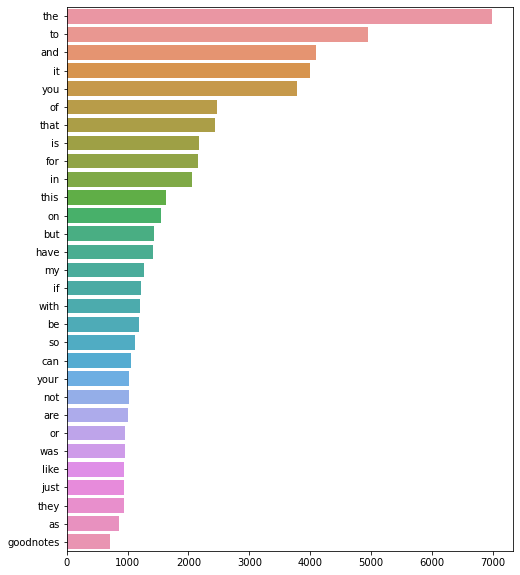

In [41]:
graph_ngrams(ngram=1)

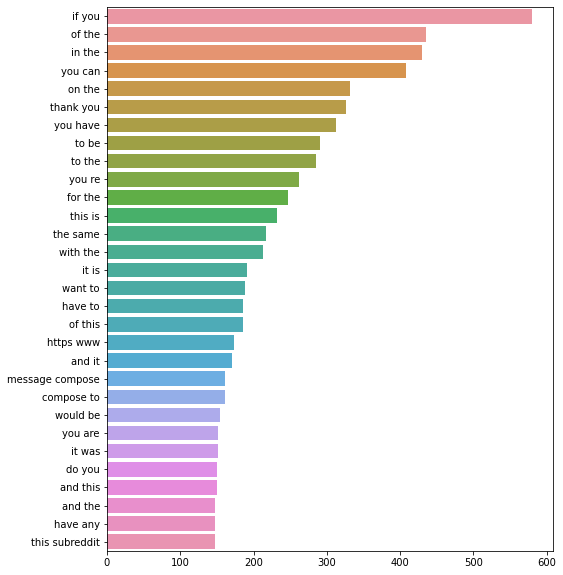

In [42]:
graph_ngrams(ngram=2)

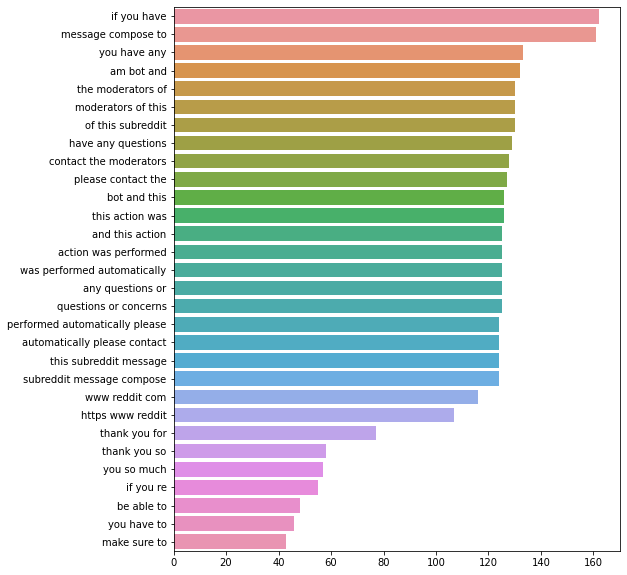

In [43]:
graph_ngrams(ngram=3)

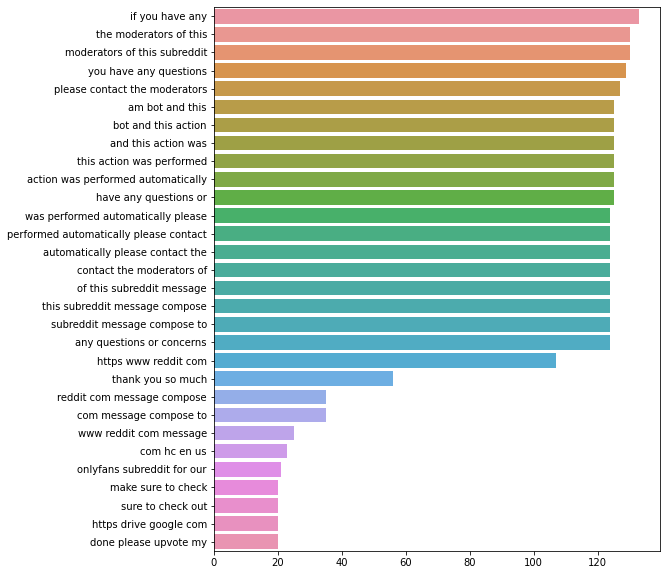

In [44]:
graph_ngrams(ngram=4)

In [45]:
df.to_csv("output/initial_eda.csv")

##  Findings from N-Gram Analysis:
* Lots of stop words in 1-gram that don't have any meaningful insights (e.g. the, and)
* Excessive use of `goodnotes` in 1-gram, which is expected given the query in the subreddit
* `thank you` or `thank you very much` appear frequently; common courtesy in social media platform
* lots of sharing to external links